# Amazon Fine Food Review Analysis

Data source : https://www.kaggle.com/snap/amazon-fine-food-reviews

EDA : https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. Contents

Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite database.sqlite: Contains the table 'Reviews'

Data includes:

Reviews from Number of reviews : 568,454 Number of Users : 256,059 users Number of Products : 74,258 products Timespan : Oct 1999 - Oct 2012 Number of Attributes/Columns : 10 260 users with > 50 reviews

Attribute Information :

    Id
    ProductId : Unique identifier for the product
    UserId : Unqiue identifier for the user
    ProfileName : Profile name of the user
    HelpfulnessNumerator : Number of users who found the review helpful
    HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not
    Score : Rating between 1 and 5
    Time : Timestamp for the review
    Summary : Brief summary of the review
    Text : Text of the review



## Loading the Dataset

After Downloading the data we can see that the data is in sqlite format which will help us to make query and visualisation simple and easy. So first Since here we have 10 attribute. So for analysis and prediction purpose we are creating another attribute in place of score attribute by simply classifying the positive scores (Score 4 and score 5) and Negative Scores (Score 1 and score 2) and will ignore the score level of 3.


In [5]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import scipy

In [7]:
connection=sqlite3.connect('database.sqlite')
final_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE SCORE!=3 LIMIT 5000""", connection)

In [14]:
def partition(x):
    if x>3:
        return 'positive'
    return 'negative'

pos_neg_score=final_data['Score']

In [15]:
print(type(pos_neg_score))
print((pos_neg_score.head()))

<class 'pandas.core.series.Series'>
0    5
1    1
2    4
3    2
4    5
Name: Score, dtype: int64


In [16]:
bool_score_updation= pos_neg_score.map(partition)

In [18]:
print(bool_score_updation.head())

0    positive
1    negative
2    positive
3    negative
4    positive
Name: Score, dtype: object


In [19]:
final_data['Score']=bool_score_updation

In [21]:
(final_data.head())

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Exploratory Data Analysis
As we have seen the data, this data contains many duplicate entries. As many discription of this data set we have come to know that this

In [23]:
display_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score!=3 AND UserId='AR5J8UI46CURR' ORDER BY ProductID""", connection);
display_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.


In [27]:
#sorting data in ascending order by ProductID
sorted_data=final_data.sort_values('ProductId', axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [30]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

In [31]:
print(final.shape)

(4986, 10)


In [32]:
#how much data is still there
print((len(final)/len(final_data))*100)

99.72


Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [34]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", connection)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [35]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [42]:
print(final.shape)
final['Score'].value_counts()

(4986, 10)


positive    4178
negative     808
Name: Score, dtype: int64

## Text Preprocessing
As we can see through the data the most important attribute is text attributes i.e. Summery and Text. So if we are able to convert anything to vector then we can perform linear algebra stuff with the data.

    So if we are able to convert the text part into the n dimension vector then we can perform many linear algebra things with that


### Stemming, Stop Words removing and lemmatization
* Removing the html tags
* Removing pancuations or special charector like or, #...
* check if the word is made up of english language or alphanumeric
* check to see if length of the word greater then 2.
* convert the words to lower case
* remove stop words
* Final Snowball stemming the word

In [43]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.


In [44]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [45]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [47]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
import re
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [48]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [49]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [50]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [51]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [52]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [53]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [56]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
#for final['text']
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████| 4986/4986 [00:02<00:00, 2333.68it/s]


In [60]:
preprocessed_reviews[1501]

'chips ahoy chewy oatmeal cookies moist difficult separate single cookie package without breaking pieces tastebuds say sweet not cooked enough lack ample chocolate chips oatmeal flakes like cookie dough likely enjoy stick crunchy less sweet cookie'

In [58]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_summery = []
# tqdm is for printing the status bar
#for final['text']
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summery.append(sentance.strip())

100%|████████████████████████████████████| 4986/4986 [00:01<00:00, 3754.07it/s]


In [61]:
preprocessed_reviews_summery[1501]

'stick keebler elves'

In [160]:
x_df=pd.DataFrame(preprocessed_reviews)


                                                   0
0  product available victor traps unreal course t...
1  used victor fly bait seasons ca not beat great...
2  received shipment could hardly wait try produc...
3  really good idea final product outstanding use...
4  glad cocker standard poodle puppy loves stuff ...


## Featurization

### KNN on Bag of Words

In [171]:
from sklearn.model_selection import train_test_split
y=list(final['Score'])
y_df=pd.DataFrame(y)

In [180]:
print(y_df.head())

          0
0  positive
1  positive
2  positive
3  positive
4  positive


In [188]:
#k_val=list(range(0,40))
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [189]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(len(y_test))

<class 'list'>
<class 'list'>
<class 'list'>
1496


In [209]:
bow_vec=CountVectorizer()
bow_vec_xtrain=(bow_vec.fit_transform(x_train)).todense()
bow_vec_xtest=(bow_vec.transform(x_test)).todense()

In [210]:
print((bow_vec_xtrain).shape)
print(bow_vec_xtest.shape)

(3490, 10999)
(1496, 10999)


In [261]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [299]:
#finding optimal k value
def finding_best_kval(x_data,y_data,algo='auto'):
    klist=list(range(1,30))
    #neighbors=list(filter(lambda x: x % 2 != 0,klist))
    #print(neighbors)
    cv_scores=[]
    for k in (klist):
        knn_model=KNeighborsClassifier(n_neighbors=k,weights='uniform',algorithm=algo,leaf_size=30,metric='cosine')
        knn_model.fit(x_data,y_data)
        score=cross_val_score(knn_model,x_data,y_data,cv=10,scoring='accuracy')
        cv_scores.append(score.mean())
        
    best_k=klist[cv_scores.index(max(cv_scores))]
    print(klist)
    print(cv_scores)
    plt.plot(klist,cv_scores,linestyle='dashed',marker='x',markerfacecolor='red')
    plt.xlabel('k-value')
    plt.ylabel('score')
    plt.show()
    return best_k

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0.7951339882657934, 0.7361047891936143, 0.8257939456387238, 0.8020108167365356, 0.8289433662211056, 0.8240763899671123, 0.8378357775676223, 0.8344006615194244, 0.8424154069097256, 0.8418489279715443, 0.845855467886196, 0.8424203471330237, 0.8404096762506998, 0.8418374337186707, 0.8452791085014185, 0.8429925849600783, 0.843557440682033, 0.8415508913574323, 0.8401206731877615, 0.8412676330684432, 0.8421264132567362, 0.842697841828165, 0.8415516912031091, 0.841838238269322, 0.8401190217416875, 0.8418324840854237, 0.841548402425885, 0.8418349400821489, 0.8406871615358918]


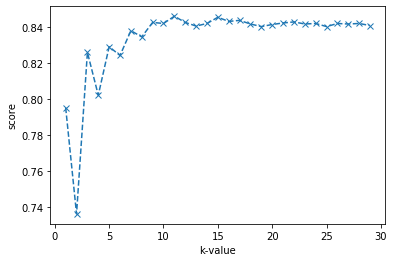

11


In [300]:
best_k=finding_best_kval(bow_vec_xtrain,y_train,algo='auto')
##knn_model=KNeighborsClassifier(n_neighbors=9,weights='uniform',algorithm='auto',leaf_size=30,metric='cosine')
#knn_model.fit(bow_vec_xtrain,y_train)
print(best_k)

In [316]:
knn_model=KNeighborsClassifier(n_neighbors=k_best,weights='uniform',algorithm='auto',leaf_size=30,metric='cosine')
knn_model.fit(bow_vec_xtrain,y_train)
#print(best_k)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [317]:
pred=knn_model.predict(bow_vec_xtest)
#prediction=knn_model.predict(bow_vec_xtest)

In [318]:
print(type(pred))
y=np.array(y_test)
from sklearn.metrics import accuracy_score
print(pred)
print(y)
print('The Accuracy of the model is : ', accuracy_score(y,pred))

<class 'numpy.ndarray'>
['positive' 'positive' 'positive' ... 'positive' 'positive' 'positive']
['positive' 'positive' 'positive' ... 'positive' 'negative' 'positive']
The Accuracy of the model is :  0.8616310160427807


In [319]:
#BoW_vec=CountVectorizer()
#BoW_vector=BoW_vec.fit_transform(preprocessed_reviews)

In [320]:
#print(BoW_vec.get_feature_names()[0:15])

In [321]:
#print(BoW_vector.get_shape())

### Bi_gram and Unigram


In [82]:
Uni_Bi_gram_vec=CountVectorizer(ngram_range=(1,2),min_df=10)

In [83]:
Uni_Bi_gram_Vector=Uni_Bi_gram_vec.fit_transform(preprocessed_reviews)

In [84]:
print(Uni_Bi_gram_Vector.get_shape())

(4986, 3144)


### Tf_idf

In [87]:
tf_idf_vec=TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_vector=tf_idf_vec.fit_transform(preprocessed_reviews)

In [89]:
print(tf_idf_vector.get_shape())

(4986, 3144)


### Word2Vec

In [92]:
from gensim.models import Word2Vec
import gensim
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [95]:
w2v_model=gensim.models.Word2Vec(list_of_sentance,min_count=5,size=50,workers=4)

In [96]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


### Converting text into vector using tfidf-w2v

In [97]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 4986/4986 [00:05<00:00, 927.52it/s]

4986
50


### avg

In [98]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [99]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 4986/4986 [00:26<00:00, 190.33it/s]
